# Sample Integration Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 31.08.2023

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../../utils")

In [ ]:
import argparse
import os
import gc
import pickle
import random
import shutil
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import plottable
import scanpy as sc
import scipy.sparse as sp
import scvi
import seaborn as sns
import squidpy as sq
import torch
from GraphST import GraphST
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import tickcross
from plottable.plots import bar
from sklearn.decomposition import KernelPCA

from nichecompass.benchmarking import compute_clisis, compute_cas
from nichecompass.models import NicheCompass

from benchmarking_utils import *

from nichecompass.utils import (create_new_color_dict)

### 1.2 Define Parameters

In [ ]:
metric_cols_sample_integration = [
    "gcs", "mlami", "cas", "clisis", # spatial conservation
    "cari", "cnmi", "casw", "clisi", # biological conservation
    "nasw", # cluster separability
    "basw", "bgc", "blisi" # batch correction
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/6), (1/6), (1/3), (1/3), # spatial conservation
    (1/4), (1/4), (1/4), (1/4), # biological conservation
    1.0, # cluster separability
    (1/3), (1/3), (1/3) # batch correction
]
metric_col_titles_sample_integration = [
    "Graph Connectivity Similarity",
    "Maximum Leiden Adjusted Mutual Info",
    "Cell Type Affinity Similarity",
    "Cell Type Local Inverse Simpson's Index Similarity",
    "Cell Type Adjusted Rand Index",
    "Cell Type Normalized Mutual Info",
    "Cell Type Average Silhouette Width",
    "Cell Type Local Inverse Simpson's Index",
    "Cluster Average Silhouette Width",
    "Batch Average Silhouette Width",
    "Batch Graph Connectivity",
    "Batch Local Inverse Simpson's Index"
]
metric_cols_single_sample = metric_cols_sample_integration[:-3]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-3]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-3]

category_cols_sample_integration = [
    "Spatial Conservation Score",
    "Biological Conservation Score",
    "Cluster Separability Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    1,
    1]
category_col_titles_sample_integration = [
    "Spatial Conservation Score (25%)",
    "Biological Conservation Score (25%)",
    "Cluster Separability Score (25%)",
    "Batch Correction Score (25%)"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Spatial Conservation Score (33%)",
    "Biological Conservation Score (33%)",
    "Cluster Separability Score (33%)"]

### 1.3 Run Notebook Setup

In [ ]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [ ]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8889")

### 1.4 Configure Paths and Create Directories

In [ ]:
data_folder_path = "../../datasets/srt_data/gold"
artifact_folder_path = f"../../artifacts"
benchmarking_folder_path = f"{artifact_folder_path}/sample_integration_method_benchmarking"

## 2. Method Benchmarking

- Run all model notebooks in the ```notebooks/sample_integration_method_benchmarking``` directory before continuing.

### 2.1 Retrieve NicheCompass Runs

#### 2.1.1 seqFISH Mouse Organogenesis

#### 2.1.2 seqFISH Mouse Organogenesis Imputed

#### 2.1.3 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [ ]:
# Add missing runs for 'nanostring_cosmx_human_nsclc_subsample_25pct'
dataset = "nanostring_cosmx_human_nsclc_subsample_25pct"
conv_layer_encoder = "gatv2conv"
timestamp = "28082023_152329_1"

adata1 = sc.read_h5ad(f"{benchmarking_folder_path}/{dataset}_nichecompass_{conv_layer_encoder}_fov.h5ad")
adata2 = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_sample_integration_method_benchmarking/{timestamp}/{dataset}_{conv_layer_encoder}_sample_integration_method_benchmarking.h5ad")

for run_number in [3]: # still running
    adata1.uns[f"nichecompass_latent_run{run_number}_umap"] = adata2.uns[f"nichecompass_latent_run{run_number}_umap"]
    adata1.uns[f"nichecompass_model_training_duration_run{run_number}"] = adata2.uns[f"nichecompass_model_training_duration_run{run_number}"]
    adata1.obsm[f"nichecompass_latent_run{run_number}"] = adata2.obsm[f"nichecompass_latent_run{run_number}"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_connectivities"] = adata2.obsp[f"nichecompass_latent_run{run_number}_connectivities"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_distances"] = adata2.obsp[f"nichecompass_latent_run{run_number}_distances"]
    
del(adata2)
gc.collect()

timestamp = "24082023_153217_1"
adata2 = sc.read_h5ad(f"{artifact_folder_path}/{dataset}/results/{conv_layer_encoder}_sample_integration_method_benchmarking/{timestamp}/{dataset}_{conv_layer_encoder}_sample_integration_method_benchmarking.h5ad")

for run_number in [4, 5, 6, 7, 8]:
    adata1.uns[f"nichecompass_latent_run{run_number}_umap"] = adata2.uns[f"nichecompass_latent_run{run_number}_umap"]
    adata1.uns[f"nichecompass_model_training_duration_run{run_number}"] = adata2.uns[f"nichecompass_model_training_duration_run{run_number}"]
    adata1.obsm[f"nichecompass_latent_run{run_number}"] = adata2.obsm[f"nichecompass_latent_run{run_number}"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_connectivities"] = adata2.obsp[f"nichecompass_latent_run{run_number}_connectivities"]
    adata1.obsp[f"nichecompass_latent_run{run_number}_distances"] = adata2.obsp[f"nichecompass_latent_run{run_number}_distances"]
    
adata1.write(f"{benchmarking_folder_path}/{dataset}_nichecompass_{conv_layer_encoder}_fov.h5ad")

In [ ]:
adata_test = sc.read_h5ad("../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_50pct_nichecompass_gatv2conv.h5ad")

In [ ]:
adata_test

In [ ]:
for i in [50, 10, 5, 1]: # 25
    adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_{i}pct_nichecompass_gatv2conv_fov.h5ad")
    adata.obs_names_make_unique()
    adata.write(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_{i}pct_nichecompass_gatv2conv_fov.h5ad")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_gatv2conv_fov.h5ad")
adata.obs_names_make_unique()
adata.write(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_nichecompass_gatv2conv_fov.h5ad")

## 2. Sample Integration Evaluation

### 2.1 Create Benchmarking Metrics Plots & Run Time Plots

#### 2.1.1 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [ ]:
datasets = ["nanostring_cosmx_human_nsclc_subsample_10pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "graphst_paste",
          "scvi"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:12]], weights=metric_col_weights_sample_integration[9:12], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst_paste": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"seqfish_mouse_organogenesis": "seqFISH Mouse Organogenesis",
     "seqfish_mouse_organogenesis_imputed": "seqFISH Mouse Organogenesis (Imputed)",
     "nanostring_cosmx_human_nsclc": "nanoString CosMx Human NSCLC"})

In [ ]:
# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.4,
    group_col="dataset",
    metric_cols=category_cols_sample_integration, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_sample_integration, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_sample_integration],
    metric_col_width=1.1, # 0.8,
    plot_width=8, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc_subsample_10pct.svg")

In [ ]:
datasets = ["nanostring_cosmx_human_nsclc",
            "nanostring_cosmx_human_nsclc_subsample_50pct",
            "nanostring_cosmx_human_nsclc_subsample_25pct",
            "nanostring_cosmx_human_nsclc_subsample_10pct",
            "nanostring_cosmx_human_nsclc_subsample_5pct",
            "nanostring_cosmx_human_nsclc_subsample_1pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "graphst_paste",
          "scvi"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:12]], weights=metric_col_weights_sample_integration[9:12], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst_paste": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 "scVI": "#FE8B3B",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "nanostring_cosmx_human_nsclc":
        return 100
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_50pct":    
        return 50
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_25pct":    
        return 25
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_10pct":    
        return 10
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_5pct":    
        return 5
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("nanoString CosMx Human NSCLC")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, custom_y_ticks)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [1, 2, 0, 3]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_slideseqv2_mouse_hippocampus.svg")
plt.show()

#### 2.1.2 seqFISH Mouse Organogenesis

In [ ]:
datasets = ["seqfish_mouse_organogenesis",
            "seqfish_mouse_organogenesis_subsample_50pct",
            "seqfish_mouse_organogenesis_subsample_25pct",
            "seqfish_mouse_organogenesis_subsample_10pct",
            "seqfish_mouse_organogenesis_subsample_5pct",
            "seqfish_mouse_organogenesis_subsample_1pct"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "graphst_paste",
          "scvi"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:12]], weights=metric_col_weights_sample_integration[9:12], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst_paste": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "GraphST": "#D78FF8",
                 "scVI": "#FE8B3B",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_50pct":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_25pct":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_10pct":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_5pct":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)

with sns.axes_style("ticks"):
    ax = sns.lineplot(data=run_time_mean_df,
                      x="dataset_share",
                      y="run_time",
                      hue="model",
                      marker='o',
                      palette=model_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("nanoString CosMx Human NSCLC")
    plt.ylabel("Run Time (Minutes)")
    plt.xlabel("Dataset Size (%)")
    custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
    plt.yscale("log")
    plt.yticks(custom_y_ticks, custom_y_ticks)
    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_linewidth(4.0)  # Adjust the size as needed
    handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
    order = [1, 2, 0, 3]
    ordered_handles = [handles[i] for i in order]
    ordered_labels = [labels[i] for i in order]
    plt.legend(ordered_handles, ordered_labels)
    ax = plt.gca()
    ax.legend().set_visible(False)
    plt.grid(True)
    plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis.svg")
    plt.show()

#### 2.1.3 seqFISH Mouse Organogenesis Imputed

#### 2.1.2 All Datasets

In [ ]:
datasets = ["seqfish_mouse_organogenesis",
            "seqfish_mouse_organogenesis_imputed",
            "nanostring_cosmx_human_nsclc"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "graphst_paste",
          "scvi"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_sample_integration[0]] = np.average(benchmark_df[metric_cols_sample_integration[:4]], weights=metric_col_weights_sample_integration[:4], axis=1)
            benchmark_df[category_cols_sample_integration[1]] = np.average(benchmark_df[metric_cols_sample_integration[4:8]], weights=metric_col_weights_sample_integration[4:8], axis=1)
            benchmark_df[category_cols_sample_integration[2]] = np.average(benchmark_df[metric_cols_sample_integration[8:9]], weights=metric_col_weights_sample_integration[8:9], axis=1)
            benchmark_df[category_cols_sample_integration[3]] = np.average(benchmark_df[metric_cols_sample_integration[9:12]], weights=metric_col_weights_sample_integration[9:12], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_sample_integration[:4]], weights=category_col_weights_sample_integration[:4] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst_paste": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    category_cols_sample_integration].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=category_cols_sample_integration, # metric_cols_single_sample,
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"seqfish_mouse_organogenesis": "seqFISH Mouse Organogenesis",
     "seqfish_mouse_organogenesis_imputed": "seqFISH Mouse Organogenesis (Imputed)",
     "nanostring_cosmx_human_nsclc": "nanoString CosMx Human NSCLC"})

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=summary_df,
                 x="Spatial Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Spatial Conservation Score", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_spatial_conservation_score.svg")
plt.show()

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Biological Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Biological Conservation Score", fontsize=12)
plt.yticks([])
plt.xticks(fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_biological_conservation_score.svg")
plt.show()

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Cluster Separability Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Cluster Separability Score", fontsize=12)
plt.yticks([])
plt.xticks(fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_cluster_separability_score.svg")
plt.show()

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Cluster Separability Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Batch Correction Score", fontsize=12)
plt.yticks([])
plt.xticks(fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_batch_correction_score.svg")
plt.show()

In [ ]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(5, 4))
ax = sns.barplot(data=summary_df,
                 x="Overall Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n', 1) if i < 3 else label.get_text().replace(' H', '\nH', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.set_yticklabels(new_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel(None)
plt.xlabel("Overall Score", fontsize=12, color="darkred")
plt.yticks([])
plt.xticks(fontsize=10, color="darkred")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_overall_score.svg")
plt.show()

### 2.1 One-Shot Batch Integration

#### 2.1.1 Latent Space Comparison Visualization

##### 2.1.1.1 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc_subsample_10pct/models/gatv2conv_sample_integration_method_benchmarking/29082023_164105_17/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model="nichecompass_gatv2conv"

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent_run2")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=0.285,
             key_added=f"leiden_0.285",
             neighbors_key=f"nichecompass_latent_run2")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_0.285")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_0.285",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_subsample_10pct_latent_clusters_{model}.svg")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_subsample_10pct_graphst_paste.h5ad")
model="graphst"

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"graphst_latent_run2")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=0.42,
             key_added=f"leiden_0.42",
             neighbors_key=f"graphst_latent_run2")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_0.42")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_0.42",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/latent_clusters_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Batches",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/batches_nanostring_cosmx_human_nsclc_subsample_10pct_{model}.svg")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/nanostring_cosmx_human_nsclc/models/gatv2conv_sample_integration_method_benchmarking/29082023_164105_17/run2/nanostring_cosmx_human_nsclc_gatv2conv_sample_integration_method_benchmarking.h5ad")
model="nichecompass_gatv2conv"

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=0.5,
             key_added=f"leiden_0.5",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_0.5")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_0.5",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_batches_{model}.svg")

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"cell_type")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Cell Types",
        model_label={model},
        cat_key=f"cell_type",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=cell_type_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_cell_types_{model}.svg")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/nanostring_cosmx_human_nsclc_scvi.h5ad")
model="scvi"

print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"scvi_latent_run2")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=0.78,
             key_added=f"leiden_0.78",
             neighbors_key=f"scvi_latent_run2")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_0.78")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_0.78",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

In [ ]:
batch_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"batch")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"batch",
        groups=None,
        sample_key="batch",
        samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
        cat_colors=batch_colors,
        size=(1440000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_batches_{model}.svg")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/visium_mouse_brain/models/gatv2conv_sample_integration_method_benchmarking/29082023_171758_1/run2/visium_mouse_brain_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/visium_mouse_brain_anterior/models/gatv2conv_sample_integration_method_benchmarking/29082023_160247_1/run2/visium_mouse_brain_anterior_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata = sc.read_h5ad(f"../../artifacts/visium_mouse_brain_posterior/models/gatv2conv_sample_integration_method_benchmarking/29082023_160247_2/run2/visium_mouse_brain_posterior_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
model = "nichecompass_gatv2conv"

In [ ]:
    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"nichecompass_latent")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=0.8,
                 key_added=f"leiden_0.8",
                 neighbors_key=f"nichecompass_latent")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"leiden_0.8")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"leiden_0.8",
            groups=None,
            sample_key="batch",
            samples=["section1", "section2"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=200,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc"
models = ["nichecompass_gatv2conv",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
adata.obs["batch"]

In [ ]:
run_number = 2

In [ ]:
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="batch",
            samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=100,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "nanostring_cosmx_human_nsclc"
models = ["nichecompass_gatv2conv_fov",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/sample_integration_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv_fov", "").replace("_gatv2conv_fov", "")
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="batch",
            samples=["lung5_rep1", "lung5_rep2", "lung5_rep3"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=100,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
adata.obs["sample"] = 

In [ ]:
adata = sc.read_h5ad("../../datasets/srt_data/gold/visium_mouse_brain_batch1.h5ad")

In [ ]:
adata.obs

In [ ]:
adata2 = sc.read_h5ad("../../datasets/srt_data/gold/visium_mouse_brain_batch2.h5ad")

In [ ]:
adata2 = sc.read_h5ad("../../datasets/srt_data/gold/visium_mouse_brain_batch2.h5ad")
adata2.obs["cell_type"] = "unannotated"
adata2.layers["counts"] = adata2.X
adata2.write("../../datasets/srt_data/gold/visium_mouse_brain_batch2.h5ad")

In [ ]:
adata.obs["in_tissue"]

In [ ]:
adata.obsm["spatial"]

In [ ]:
adata.obsm["spatial"][:, 0]

In [ ]:
adata.X.toarray()

In [ ]:
sq.pl.spatial_scatter(adata, color="in_tissue", shape=None, figsize=(12, 12))  

### STARmap

In [ ]:
adata = sc.read_h5ad("../../artifacts/starmap_plus_mouse_cns/models/gatv2conv_sample_integration_method_benchmarking/30082023_124855_1/run2/starmap_plus_mouse_cns_gatv2conv_sample_integration_method_benchmarking.h5ad")

In [ ]:
model = "nichecompass_gatv2conv"

In [ ]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key="Main_molecular_cell_type")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key="Main_molecular_cell_type",
        groups=None,
        sample_key="batch",
        samples=["sagittal1", "sagittal2", "sagittal3"],
        cat_colors=cell_type_colors,
        size=(1440000 / len(adata)),
        spot_size=0.1,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/starmap_plus_mouse_cns_cell_types_{model}.svg")

In [ ]:
latent_cluster_colors

In [ ]:
print("\nComputing UMAP embedding...")
sc.tl.umap(adata,
           neighbors_key=f"nichecompass_latent")

print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=1.0,
             key_added=f"leiden_1.0",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_1.0")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_1.0",
        groups=None,
        sample_key="batch",
        samples=["sagittal1", "sagittal2", "sagittal3"],
        cat_colors=latent_cluster_colors,
        size=(720000 / len(adata)),
        spot_size=0.1,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_latent_clusters_{model}.svg")

##### 4.1.3.3 Compute Batch Integration Metrics

In [ ]:
adata = sc.read_h5ad("../../datasets/srt_data/results/sample_integration_method_benchmarking/seqfish_mouse_organogenesis_graphst_sample_integration_method_benchmarking.h5ad")

In [ ]:
adata

In [ ]:
compute_batch_integration_metrics(dataset="seqfish_mouse_organogenesis",
                                  condition_key="batch",
                                  cell_type_key="cell_type",
                                  srt_data_results_folder_path=srt_data_results_folder_path,
                                  metric_artifacts_folder_path=metric_artifacts_folder_path,
                                  included_models=[#"NicheCompass",
                                                   "GraphST",
                                                   "scVI"])

##### 4.1.3.4 Visualize Batch Integration Results

In [ ]:
df = pd.DataFrame()
datasets = ["starmap_plus_mouse_cns",]
timestamps = ["27032023_184359"]

for dataset, timestamp in zip(datasets, timestamps):
    dataset_metric_artifacts_folder_path = f"../artifacts/{dataset}/metrics/{timestamp}"
    
    metrics_dict_list = []
    for model in ["NicheCompass", "GraphST", "scVI"]:
        # Read complete benchmarking data from disk
        with open(f"{dataset_metric_artifacts_folder_path}/metrics_{model.lower()}_oneshot_integrated.pickle", "rb") as f:
            metrics_dict = pickle.load(f)
            metrics_dict["model_name"] = model.lower()
            metrics_dict_list.append(metrics_dict)
    
    dataset_df = pd.DataFrame(metrics_dict_list)
    dataset_df["dataset"] = dataset

df = pd.concat([df, dataset_df])
df.head()

columns = ["cas",
           "clisis",
           "asw",
           "ilisi",
           ]

rows = ["nichecompass",
        "graphst",
        "scvi"]

unrolled_df = pd.melt(df, 
   id_vars = ["model_name", "dataset"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

# Compute metric means over all runs
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()
mean_df.reset_index(inplace=True)

# Reformat for plot
mean_df.replace({"nichecompass": "NicheCompass",
                 "graphst": "GraphST",
                 "scvi": "scVI"}, inplace=True)

# Sort for right order of columns in plottable
mean_df["score_type"] = pd.Categorical(mean_df["score_type"], ["cas", "clisis", "asw", "ilisi"])
mean_df.sort_values(["model_name", "score_type"], inplace=True)

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model_name"] in ["NicheCompass", "GraphST"]:
        return True
    return False
mean_df["spatially_aware"] = mean_df.apply(lambda row: is_spatially_aware_model(row), axis=1)

In [ ]:
plot_batch_integration_results(mean_df,
                               show=True,
                               save_dir=None,
                               save_name="batch_integration_results.svg")

##### 4.1.3.4 Scalability

In [ ]:
datasets = ["seqfish_mouse_organogenesis", "starmap_plus_mouse_cns"]
models = ["NicheCompass (Attention Aggregator)", "NicheCompass (Norm Aggregator)", "GraphST", "scVI"]

run_time_dict = {"Dataset": [],
                 "Model": [],
                 "Dataset Size (%)": [],
                 "Mean Runtime (s)": []}

for dataset in datasets:
    for model in models:
        for subsample_pct in [1, 5, 10, 25, 50, 100]:
            if model == "NicheCompass (Attention Aggregator)":
                model_subtype = "nichecompass_one-hop-attention"
                model_str = "nichecompass"
            elif model == "NicheCompass (Norm Aggregator)":
                model_subtype = "nichecompass_one-hop-norm"
                model_str = "nichecompass"
            else:
                model_subtype = model
                model_str = model
                
            if subsample_pct == 100:
                subsample_str = ""
            else:
                subsample_str = f"_subsample_{subsample_pct}pct"

            try:
                adata = sc.read_h5ad(f"{srt_data_results_folder_path}/{dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")
            except:
                print(f"Did not load {dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")
                continue
                
            print(f"Loaded {dataset}{subsample_str}_{model_subtype.lower()}_sample_integration_method_benchmarking.h5ad")

            run_times = []
            for run_number in range(1, 11):
                run_times.append(adata.uns[f"{model_str.lower()}_model_training_duration_run{run_number}"])
            run_time_dict["Dataset"].append(dataset)
            run_time_dict["Model"].append(model)
            run_time_dict["Dataset Size (%)"].append(subsample_pct)
            run_time_dict["Mean Runtime (s)"].append(np.mean(run_times))

run_time_df = pd.DataFrame(run_time_dict)
display(run_time_df)

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot the first lineplot in the first subplot
sns.lineplot(x="Dataset Size (%)", y="Mean Runtime (s)", hue=run_time_df["Model"], data=run_time_df[run_time_df["Dataset"] == "seqfish_mouse_organogenesis"], marker="o", ax=axs[0])
axs[0].set_title("seqFISH Mouse Organogenesis")

# Plot the second lineplot in the second subplot
sns.lineplot(x="Dataset Size (%)", y="Mean Runtime (s)", hue=run_time_df["Model"], data=run_time_df[run_time_df["Dataset"] == "starmap_plus_mouse_cns"], marker="o", ax=axs[1], legend=False)
axs[1].set_title("STARmap PLUS Mouse CNS")

# Remove the legend title
leg = axs[0].legend()
leg.set_title("")

# Add a grid to both subplots
for ax in axs:
    ax.grid(True, linewidth=0.2, color='lightgrey')
    
plt.subplots_adjust(wspace=0.05)

plt.savefig(f"{figure_folder_path}/method_comparison_scalability.svg",
            bbox_inches="tight")
plt.show()

### 4.2 Query-to-Reference Mapping

#### 3.3.1 Reference

In [ ]:
adata.write(f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference.h5ad")

In [ ]:
adata = sc.read_h5ad(f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference.h5ad")

In [ ]:
adata

In [14]:
latent_leiden_resolution

0.6

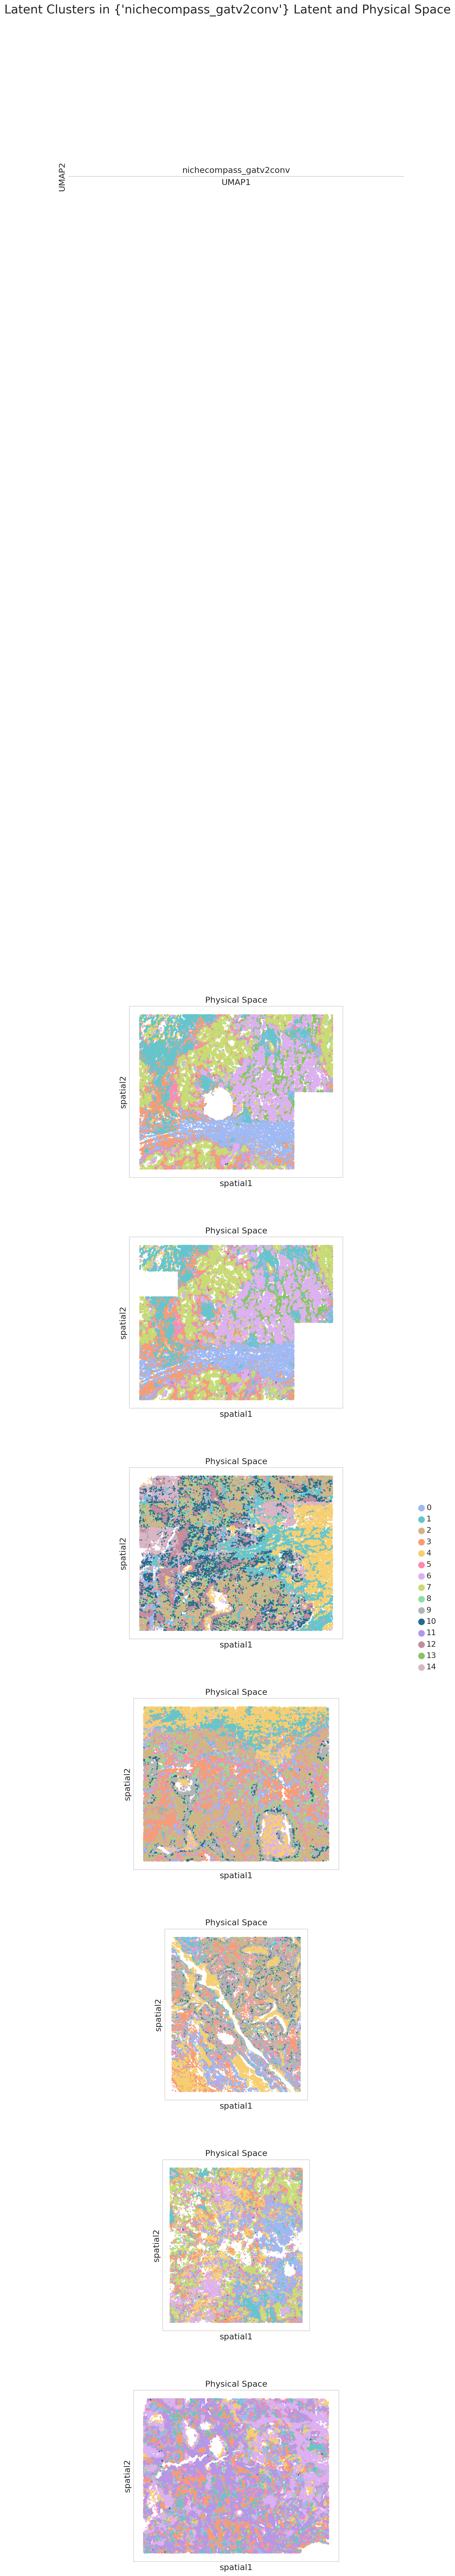

In [13]:
print("\nComputing Leiden clustering...")
sc.tl.leiden(adata=adata,
             resolution=latent_leiden_resolution,
             key_added=f"leiden_{latent_leiden_resolution}",
             neighbors_key=f"nichecompass_latent")

latent_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=f"leiden_{latent_leiden_resolution}")

plot_category_in_latent_and_physical_space(
        adata=adata,
        plot_label="Latent Clusters",
        model_label={model},
        cat_key=f"leiden_{latent_leiden_resolution}",
        groups=None,
        sample_key="batch",
        samples=adata.obs["batch"].unique().tolist(),
        cat_colors=latent_cluster_colors,
        size=(360000 / len(adata)),
        spot_size=200,
        save_fig=True,
        file_path=f"{benchmarking_folder_path}/nanostring_cosmx_human_nsclc_reference_latent_clusters_{model}.svg")

#### 3.3.2 Mapping the Query

##### 3.3.2.1 Initialize, Train & Save Model

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

##### 4.1.1.2 GraphST

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

#### 4.1.2 NicheCompass

In [ ]:
model_name = "NicheCompass"

# Load trained model
model = NicheCompass.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}_reference.h5ad",
                        gp_names_key="nichecompass_gp_names")

adata_reference = model.adata

# Use NicheCompass latent representation for UMAP generation
sc.pp.neighbors(adata_reference,
                use_rep=f"{model_name.lower()}_{latent_key}")
sc.tl.umap(adata_reference)

# Save integrated adata to disk
adata_reference.write(f"{srt_data_gold_folder_path}/{dataset}_{model_name.lower()}_oneshot_integrated.h5ad")

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title(f"One-Shot Integration: {model_name} Latent Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")

# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference,
                 color=[cell_type_key],
                 palette=starmap_pluse_mouse_cns_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_reference),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title(f"One-Shot Integration: {model_name} Latent Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_{model_name.lower()}_oneshot_integrated.svg",
            bbox_inches="tight",
            format="svg")